## The grid cell system model is a spiking neural network (SNN) model written in pyNEST (2.18)
@author R Stentiford

In this experiment a grid cell attractor network is built using interactions between and excitatory and inhibitory population. Four conjunctive layers driven by the translational velocity drive the activity bump across the sheet

A constant velocity spiral is used to observe the griddiness of these network parameters

IN THIS EXAMPLE SMALLER CELL POPULATIONS WERE USED
- this resulted in less stable grid fields

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats
import pandas as pd

sim.ResetKernel()

mins = 1. #3.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')

simulation length: 1.0 mins = 60000 ms


In [ ]:
prm = dict()
prm['pixel_ratio'] = 440
prm['output_path'] = 'GridAnalysis/small_network'
path = prm['output_path']

### Params

In [5]:
y_dim = (0.5* np.sqrt(3))
Nx = 10
Ny = int(np.ceil(Nx * y_dim))
N = Nx * Ny
print(f'{Nx} x {Ny} = {N}')


sigma = 0.5/6 #0.12
mu = 0.5
delay = 0.1
base_ex = 4000
base_in = 450
base_cj = 2000.
w_ex_cj = 500.

I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = N//2

10 x 9 = 90


### Create populations

In [3]:
exc = sim.Create("iaf_psc_alpha",N, params={"I_e": 400.})
inh = sim.Create("iaf_psc_alpha",N)

l = sim.Create("iaf_psc_alpha",N)
r = sim.Create("iaf_psc_alpha",N)
u = sim.Create("iaf_psc_alpha",N)
d = sim.Create("iaf_psc_alpha",N)

### Define connections

Attractor dynamics emerge through reciprocal connections between cells in the excitatory population and inhibitory population. Each excitatory cell connects to a subset of inhibitory neurons with declining synaptic strength as a function of distance. Reciprocal inhibitory connections from each inhibitory cell to excitatory cells are arranged with synaptic strength decreasing as a function of distance offset by a constant (mu).

This arrangement provides inhibitory input to the cells surrounding the most active excitatory cell, producing a single stable bump of activity.

Cells are arranged as 2D sheets with twisted torus wrap around connectivity for the purpose of defining synaptic strength based on distance. See Guanella et al 2007 for a full description of this connectivity structure and the origin of the following calculations.

In [5]:
def twistedTorus(x_e,y_e,x_i,y_i,y_dim):
        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d3 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d4 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d5 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d7 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i)**2)
        
        return min(d1,d2,d3,d4,d5,d6,d7)

In [6]:
w_ex = np.empty((N,N))
w_in = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = y_dim*(e//Nx)/ Ny
    for i in range(N): 
        x_i = (i%Nx) / Nx 
        y_i = y_dim*(i//Nx) / Ny
        
        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)

        w_gauss = np.exp(-(d_)**2/2/sigma**2)
        w_ring = np.exp(-(d_ - mu)**2/2/sigma**2)

        w_ex[i,e] = base_ex * w_ring
        w_in[e,i] = base_in * w_gauss

w_ex[w_ex<10]=0
w_in[w_in<10]=0

In order to track translaiton based on velocity the four populations of conjunctive cells are connected one to one with an excitatory cell, shifted one cell u, down, left or right on the sheet from the equivalently positioned neuron.

The same distance dependent calculation is performed, using ofset positions of the inhibitory cell, with only the strongest connection maintained. Due to the twisted torus configuration and the ydim parameter this may be more than one cell with lower weights.

In [7]:
w_l = np.empty((N,N))
w_r = np.empty((N,N))
w_u = np.empty((N,N))
w_d = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = (e//Nx) / Ny * y_dim
    for i in range(N): 
        x_i = ((i%Nx) / Nx) - (1/Nx) 
        y_i = (i//Nx) / Ny * y_dim
        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_l[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = ((i%Nx) / Nx) + (1/Nx) 
        y_i = (i//Nx) / Ny * y_dim
        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_r[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))        

        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) + (1 / Ny * y_dim)
        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_u[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) - (1 / Ny * y_dim)
        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_d[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0
m = np.amax(w_u)
w_u[w_u<m] = 0
m = np.amax(w_d)
w_d[w_d<m] = 0

In [6]:
exc_2_inh = sim.Connect(exc,inh,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
inh_2_exc = sim.Connect(inh,exc,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})

exc_2_l = sim.Connect(exc,l,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_r = sim.Connect(exc,r,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_u = sim.Connect(exc,u,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_d = sim.Connect(exc,d,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

l_2_exc = sim.Connect(l,exc,'all_to_all',syn_spec={'weight': w_l, 'delay': delay})
r_2_exc = sim.Connect(r,exc,'all_to_all',syn_spec={'weight': w_r, 'delay': delay})
u_2_exc = sim.Connect(u,exc,'all_to_all',syn_spec={'weight': w_u, 'delay': delay})
d_2_exc = sim.Connect(d,exc,'all_to_all',syn_spec={'weight': w_d, 'delay': delay})

### Network input

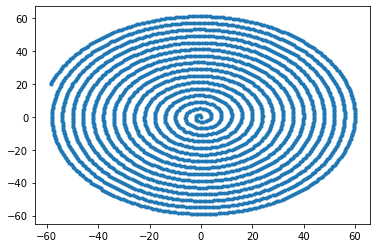

In [8]:
dt = 20
t = np.arange(0,sim_len,dt)*1.
time = [i * 1. for i in t if i < sim_len]
ts = np.arange(0,sim_len,dt)/1000.
V = 50
dr = 4
ph = np.sqrt(((V * (4*np.pi) * ts) / dr))
ra =  np.sqrt(((V * dr * ts) / np.pi))

pos_x = ra * np.cos(ph) 
pos_y = ra * np.sin(ph)
plt.plot(pos_x,pos_y,'.')

In [9]:
vel_x = np.diff(pos_x)
vel_y = np.diff(pos_y)

speed = np.sqrt(vel_x**2 + vel_y**2)
speed = np.append(speed, np.nan)

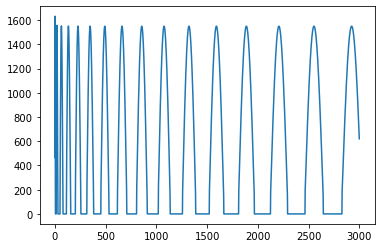

In [11]:
vel_x,vel_y = vel_x*1400, vel_y*1400

sh = 150
go_l,go_r = vel_x,-vel_x
go_u,go_d = vel_y,-vel_y
go_l, go_r, go_u, go_d = go_l+sh, go_r+sh, go_u+sh, go_d+sh
go_l[go_l<=sh] = 0.
go_r[go_r<=sh] = 0.
go_u[go_u<=sh] = 0.
go_d[go_d<=sh] = 0.

plt.plot(go_r)

l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(l_input,{'amplitude_times': t[1:],'amplitude_values': go_l})
r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(r_input,{'amplitude_times': t[1:],'amplitude_values': go_r})
u_input = sim.Create('step_current_generator', 1)
sim.SetStatus(u_input,{'amplitude_times': t[1:],'amplitude_values': go_u})
d_input = sim.Create('step_current_generator', 1)
sim.SetStatus(d_input,{'amplitude_times': t[1:],'amplitude_values': go_d})

In [12]:
sim.Connect(l_input,l,'all_to_all')
sim.Connect(r_input,r,'all_to_all')
sim.Connect(u_input,d,'all_to_all')
sim.Connect(d_input,u,'all_to_all')

### Record spikes

In [13]:
exc_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
sim.Connect(exc,exc_spikes)

### Init bump

In [14]:
bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc[I_init_pos]])

### Run simulation

In [15]:
tic = tm.time()
sim.Simulate(sim_len)
print(f'Simulation run time: {np.around(tm.time()-tic,2)}s  Simulated time: {np.around(sim_len/1000,2)}s')

Simulation run time: 19.68s  Simulated time: 60.0s


52


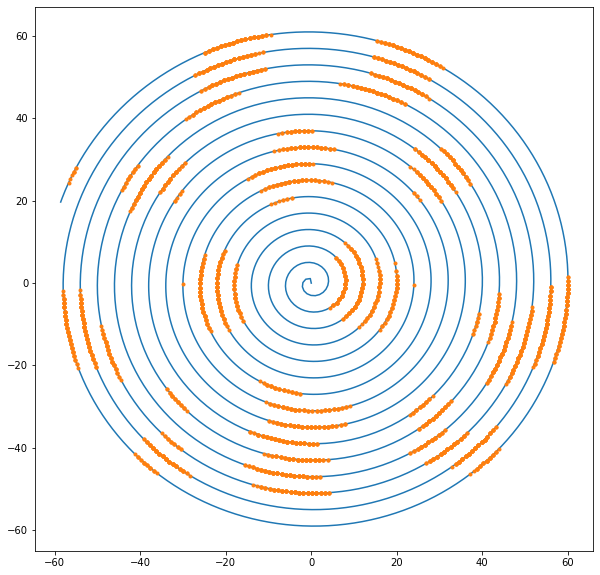

In [17]:
from collections import Counter 
ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

occurence_count = Counter(sp) 
# print(occurence_count)
cell = occurence_count.most_common(5)[0][0]
print(cell)

spktms = t[sp==cell]
spktms = (spktms//20)*20
spktms=spktms[1:]

xs = np.empty((len(spktms)))
ys = np.empty((len(spktms)))

for i,spk in enumerate(spktms):
    if spk < 60000:
        xs[i] = pos_x[np.where(time == spk)[0][0]]
        ys[i] = pos_y[np.where(time == spk)[0][0]]
        
fig = plt.figure(figsize=(10, 10),facecolor='w')
plt.plot(pos_x[:len(time)],pos_y[:len(time)])
plt.plot(xs,ys,'.')

In [10]:
spatial_data = pd.DataFrame({
                            'position_x' : pos_x - min(pos_x),
                            'position_y' : pos_y - min(pos_y),
                            'speed' : speed,
                            'sim_len' : sim_len
                            })
spatial_data = pd.DataFrame.from_dict(spatial_data)
# spatial_data.to_pickle(f"{path}/spatial_data.pkl")

In [18]:
spike_data = pd.DataFrame()
for cell in set(sp):
    if cell % 3 == 0: #ONLY SAVE EVERY 3RD CELL
        spktms = t[sp==cell]
        spktms = (spktms//20)*20

        xs = np.empty((len(spktms)))
        ys = np.empty((len(spktms)))

        for i,spk in enumerate(spktms):
            if spk < 60000:
                xs[i] = pos_x[np.where(time == spk)[0][0]]
                ys[i] = pos_y[np.where(time == spk)[0][0]]

        spike_data = spike_data.append({'cell_id': int(cell),
                                        'spike_times': spktms, 
                                        'number_of_spikes': len(spktms),
                                        'mean_firing_rate': len(spktms)/(sim_len/1000),
                                        'position_x': xs - min(pos_x),
                                        'position_y': ys - min(pos_y)
                                        }, ignore_index=True)

# spike_data.to_pickle(f"{path}/spike_data.pkl")

In [19]:
spike_data

,cell_id,mean_firing_rate,number_of_spikes,position_x,position_y,spike_times
0,3.0,54.766667,3286.0,"[63.69540274551625, 63.69540274551625, 63.6954...","[65.9023026858811, 65.9023026858811, 65.902302...","[1160.0, 1160.0, 1160.0, 1180.0, 1180.0, 1180...."
1,6.0,45.516667,2731.0,"[60.17143813495661, 60.17143813495661, 59.1886...","[67.74209150316118, 67.74209150316118, 67.9372...","[1240.0, 1240.0, 1260.0, 1260.0, 1260.0, 1320...."
2,9.0,47.883333,2873.0,"[57.1146419511798, 57.1146419511798, 58.090755...","[52.2952628288222, 52.2952628288222, 52.063093...","[740.0, 740.0, 760.0, 760.0, 760.0, 820.0, 840..."
3,12.0,57.600000,3456.0,"[65.57997567290988, 65.57997567290988, 65.5799...","[63.57763682596256, 63.57763682596256, 63.5776...","[1100.0, 1100.0, 1100.0, 1120.0, 1120.0, 1120...."
4,15.0,45.500000,2730.0,"[60.14317776838282, 60.14317776838282, 59.2013...","[63.524731213991046, 63.524731213991046, 63.88...","[360.0, 360.0, 380.0, 380.0, 380.0, 1140.0, 11..."
5,18.0,46.833333,2810.0,"[54.28595103162817, 54.28595103162817, 53.3902...","[67.2603710613426, 67.2603710613426, 66.811658...","[1360.0, 1360.0, 1380.0, 1380.0, 1380.0, 1380...."
6,21.0,57.516667,3451.0,"[66.32521303908253, 66.00897396286486, 66.0089...","[61.72062206301933, 62.67177825106121, 62.6717...","[1060.0, 1080.0, 1080.0, 1080.0, 1080.0, 1100...."
7,24.0,48.233333,2894.0,"[62.54121794919636, 62.22525262848894, 62.2252...","[60.444807369653184, 61.402576533743286, 61.40...","[280.0, 300.0, 300.0, 300.0, 320.0, 320.0, 320..."
8,27.0,48.616667,2917.0,"[58.34733576881305, 57.2886005568601, 57.28860...","[60.107642695178015, 59.94865767750039, 59.948...","[20.0, 40.0, 40.0, 40.0, 60.0, 60.0, 60.0, 60...."
9,30.0,50.683333,3041.0,"[49.87882955122855, 49.42105999840415, 49.4210...","[63.31781734369456, 62.426845836425635, 62.426...","[1480.0, 1500.0, 1500.0, 2340.0, 2360.0, 2360...."
